In [20]:
import pandas as pd
import numpy
import json
import seaborn as sns
import matplotlib as mpl
from scipy import stats

sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [21]:

def vek(vstup):
    try:
        return int(abs(float(vstup)))/1000 if abs(float(vstup)) > 1000 else int(abs(float(vstup)))
    except ValueError:
        return numpy.nan
    

konvertovace = {
    'age' : vek
}

personalne = pd.read_csv("data/personal_train.csv", na_values='?', index_col=0, converters=konvertovace, )
personalne = personalne.drop(columns='date_of_birth')

Nacitane personalne data, s opravenym vekom, odstranenym datumom narodenia (nie je potrebny)

In [22]:
bulo = lambda vstup: numpy.nan if pd.isna(vstup) or len(str(vstup).strip()) is 0 else str(vstup).strip().lower().split('.')[0][0] == 't'
classa = lambda vstup: vstup.lower().split('.|')[0]


def js(vstup):
    try:
        return str(vstup).replace("'", '"')
    except json.JSONDecodeError:
        pass
konvertovace = {
    "FTI measured": bulo,
    "tumor": bulo,
    "lithium": bulo,
    "thyroid surgery": bulo,
    "I131 treatment": bulo,
    "goitre": bulo,
    "hypopituitary": bulo,
    "query on thyroxine": bulo,
    "T3 measured": bulo,
    "TBG measured": bulo,
    "pregnant": bulo,
    "class": classa,
    "medical_info": js
}
other = pd.read_csv("data/other_train.csv", na_values=['?', '??', ' ?'], index_col=0, true_values=['t'],
                    false_values=['f'],
                    converters=konvertovace)
other = other.drop(columns=['TBG'])


Nacitane ostatne udaje s opravenymi boolovskymi hodnotami a vyhodenym prazdnym stlpcom TBG

In [23]:
def rozober_json(vstup):
    try:
        return pd.Series(json.loads(vstup))
    except json.JSONDecodeError:
        return pd.Series(json.loads('{}'))
other = other.join(other['medical_info'].apply(rozober_json))
other = other.drop(columns='medical_info')

Rozoberanie jsonu v medical_info stlpci na jednotlive stlpce

In [24]:
for stlpec in ['TSH measured', 'query hyperthyroid', 'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych', 'query hypothyroid']:
    other[stlpec] = other[stlpec].apply(bulo)

other = other.replace('?', numpy.nan)

Oprava pridanych boolovskych stlpcov a nahradenie ? za NaN

In [25]:
vsetko = other.merge(personalne, on=('name', 'address'))
vsetko = vsetko.replace(to_replace=[None], value=numpy.nan)


Spojenie suborov a nahradenie None za NaN

In [26]:
def agreguj(vstup):
    vstup = vstup.reset_index()
    for hodnota in vstup.values:
        if not pd.isna(hodnota[1]) and str(hodnota[1]).strip() != '':
            # if not pd.isna(prvy) and prvy != hodnota[1]:
            #     print('!!!!!' + prvy + ' ' + str(hodnota[1]) + ' ' + str(hodnota[0]))
            return hodnota[1]
    return numpy.nan


In [27]:
vsetko = vsetko.groupby(['name', 'address']).aggregate(agreguj).reset_index()


,name,address,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,on thyroxine,...,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,age,sex
0,Aaron Johansen,"3642 Melissa Crest\nNew Alicia, KS 60976",True,HS-grad,False,67.0,0.930,2001.0,0.0,False,...,False,True,False,72,False,True,False,False,1.3,M
1,Abigail Martinez,"5009 Lynch Highway\nSharonmouth, KS 23172",True,HS-grad,False,103.0,1.050,0.0,0.0,False,...,False,True,False,98,False,True,False,False,34.0,F
2,Abraham Bruce,"49824 Kim View\nWest Ericborough, VT 42457",True,Some_college,False,91.0,0.800,0.0,3908.0,False,...,False,True,False,113,False,True,False,False,73.0,M
3,Abraham Hicks,Unit 3701 Box 5448\nDPO AP 04047,True,Prof-school,False,71.0,1.000,0.0,0.0,False,...,False,True,False,71,False,True,False,False,55.0,M
4,Ada Jeffries,Unit 8721 Box 6441\nDPO AP 00654,True,Some_college,False,112.0,0.990,0.0,0.0,True,...,False,True,False,113,False,True,False,False,80.0,F
5,Ada Wells,"839 Waters Ridge\nSouth Julia, WV 61126",True,HS-grad,False,184.0,1.190,0.0,0.0,False,...,False,True,False,155,False,True,False,False,53.0,F
6,Adam Wolfgram,"4339 Howard Junction Suite 024\nMarshallside, ...",True,Some-college,False,122.0,0.800,0.0,0.0,False,...,False,True,False,152,False,True,False,False,7.4,M
7,Adam Zabinski,"748 Vanessa Plaza Apt. 476\nJessicastad, MI 79738",True,9th,False,74.0,0.770,0.0,0.0,True,...,False,True,False,96,False,True,False,False,37.0,M
8,Addie Taggart,"40936 Singh Underpass\nRichardfurt, PA 64832",True,Masters,False,54.0,0.780,0.0,0.0,False,...,False,True,False,70,False,True,False,False,56.0,F
9,Adrian Carvalho,"7684 Osborne Squares Apt. 212\nTrevormouth, WY...",True,HS-grad,False,138.0,1.210,0.0,0.0,True,...,False,True,False,115,False,True,False,False,28.0,NaN


Spojenie rovnakych riadkov. Momentalne berieme prvu neprazdnu hodnotu. V pripade ze by bolo neprazdnych hodnot viac, dal by sa pouzit priemer pre numericke atributy a modus pre kategoricke, pripadne najcastejsia hodnota v celom datasete ak by pocet vyskytov bol rovnaky.

In [28]:
vsetko.FTI = pd.to_numeric(vsetko.FTI)

In [29]:
vsetko = vsetko[vsetko['class']!='']

Odstranenie riadkov s prazdnou hodnotou class - tieto riadky by nam pri trenovani nepomohli

In [30]:
nenumericke = vsetko.select_dtypes(exclude=numpy.number).columns
modusy = {}
for stlpec in nenumericke:
    modusy[stlpec] = vsetko[stlpec].mode()
modusove = vsetko.replace(numpy.nan, value=modusy)


Doplnenie kategorickych atributov najcastejsou hodnotou

In [31]:
numericke = vsetko.select_dtypes(include=numpy.number).columns
mediany = {}
for stlpec in numericke:
    mediany[stlpec] = vsetko[stlpec].median()
medianove = vsetko.replace(numpy.nan, value=mediany)

Doplnenie chybajucich hodnot numerickych atributov medianom

In [32]:
medianove.to_csv(path_or_buf='data/opravene_spojene_medianom.csv')

In [33]:
linearne = vsetko.interpolate()

Doplnenie chybajucich numerickych atributov pomocou linearnej regresie

In [34]:
linearne.to_csv(path_or_buf='data/opravene_spojene_linearne.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1FBD522B0>,
      dtype=object)

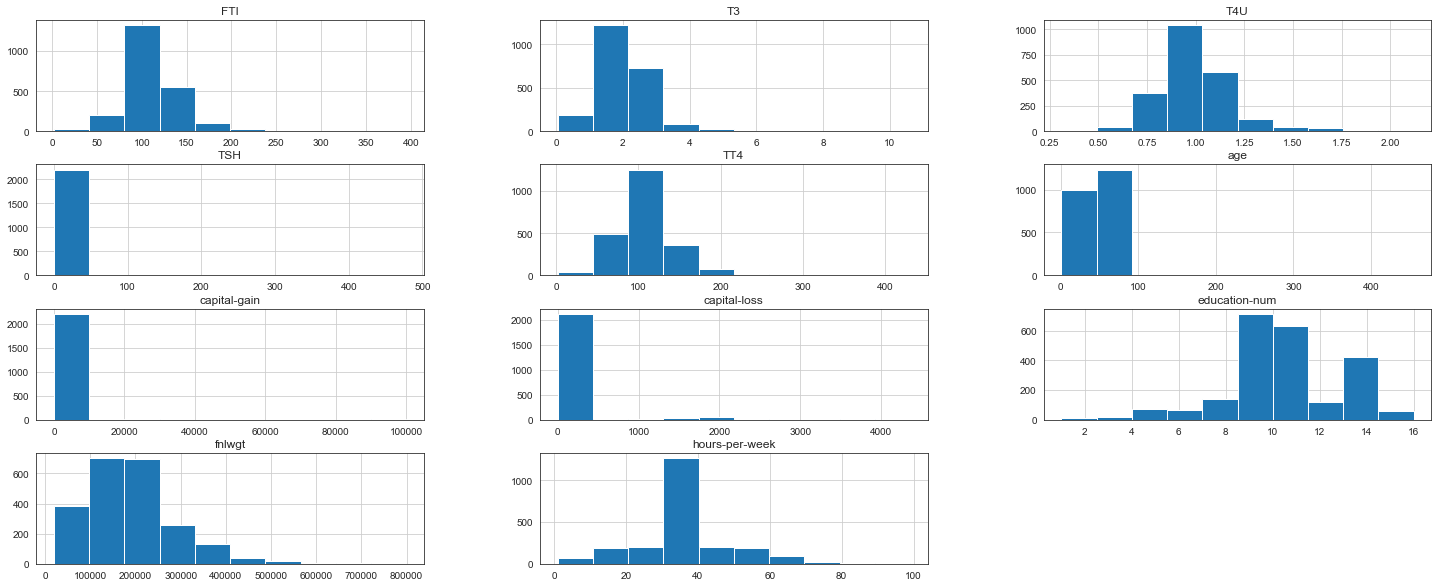

In [35]:
linearne.select_dtypes(exclude=bool).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1803D36D8>,
      dtype=object)

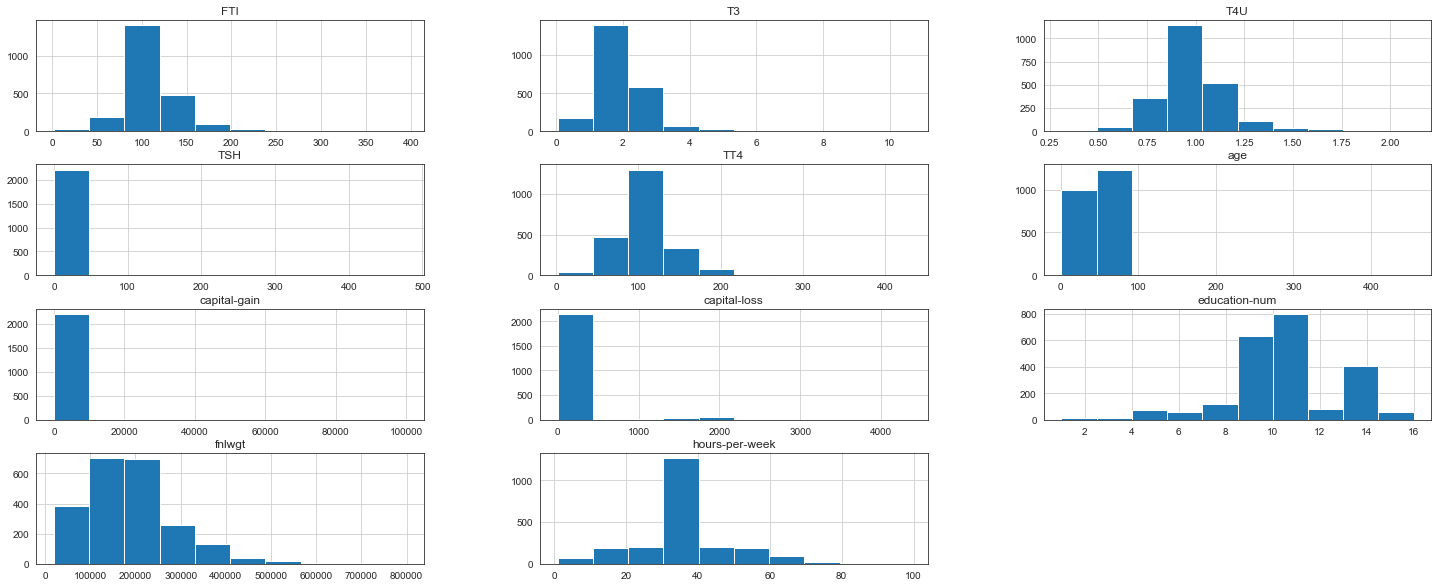

In [36]:
medianove.select_dtypes(exclude=bool).hist()

Doplnenie chybajucich hodnot medianom a linearnou regresiou davaju porovnatelny vysledok.

In [37]:
for col in linearne.select_dtypes(include=numpy.number).columns:
    linearne[col] = linearne[numpy.abs(linearne[col]-linearne[col].mean()) <= (3*linearne[col].std())]
    
linearne.head()

,name,address,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,on thyroxine,...,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,age,sex
0,Aaron Johansen,"3642 Melissa Crest\nNew Alicia, KS 60976",True,HS-grad,False,Aaron Johansen,Aaron Johansen,NaN,Aaron Johansen,False,...,False,True,False,Aaron Johansen,False,True,False,False,Aaron Johansen,M
1,Abigail Martinez,"5009 Lynch Highway\nSharonmouth, KS 23172",True,HS-grad,False,Abigail Martinez,Abigail Martinez,Abigail Martinez,Abigail Martinez,False,...,False,True,False,Abigail Martinez,False,True,False,False,Abigail Martinez,F
2,Abraham Bruce,"49824 Kim View\nWest Ericborough, VT 42457",True,Some_college,False,Abraham Bruce,Abraham Bruce,Abraham Bruce,Abraham Bruce,False,...,False,True,False,Abraham Bruce,False,True,False,False,Abraham Bruce,M
3,Abraham Hicks,Unit 3701 Box 5448\nDPO AP 04047,True,Prof-school,False,Abraham Hicks,Abraham Hicks,Abraham Hicks,Abraham Hicks,False,...,False,True,False,Abraham Hicks,False,True,False,False,Abraham Hicks,M
4,Ada Jeffries,Unit 8721 Box 6441\nDPO AP 00654,True,Some_college,False,Ada Jeffries,Ada Jeffries,Ada Jeffries,Ada Jeffries,True,...,False,True,False,Ada Jeffries,False,True,False,False,Ada Jeffries,F


In [38]:
medianove[medianove['age']>100]

,name,address,FTI measured,education,lithium,TT4,T4U,capital-loss,capital-gain,on thyroxine,...,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,age,sex
1976,Stacey Cameron,04072 Catherine Pike Apt. 610\nPort Richardbur...,True,HS-grad,False,152.0,0.93,0.0,0.0,False,...,False,True,False,163.0,False,True,False,True,200.0,F
2032,Susana Marshall,"96194 Lindsay Viaduct\nMillertown, WY 92869",True,Some_college,False,118.0,1.13,0.0,0.0,False,...,False,True,False,104.0,False,True,False,False,455.0,F
